In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.path as mpath
import matplotlib.patches as mpatches
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'font.size': 12})
#plt.rcParams.update({"font.family": "Verdana"})
#plt.rcParams.update({"text.usetex": True})
#plt.rcParams.update(plt.rcParamsDefault)

plt.rcParams.update({'font.family': 'serif'})

#plt.rcParams['font.family'] = 'serif'
#plt.rcParams['font.serif'] = 'Comic Sans MS'

import networkx as nx

from utils import distance
from utils.distance import average_distance
from utils import CommonFunctions as CF

from scipy.integrate import solve_ivp
from scipy.linalg import eig

from galib import models as HM

# SIS Model

In [2]:
N = 128

#HMshape = [2,2,32]
#avklist = [1,4,20]
np.random.seed(1)

HMshape = [2,2,32]
avklist = [1,3,20]

mat = HM.HMRandomGraph(HMshape, avklist)

In [3]:
Rs = np.arange(0.0, 0.3, 0.005)
B = 1

X_mean_epi = np.zeros(len(Rs))
X_mean_low_epi = np.zeros(len(Rs))

dynamics = 'Epidemics'
init_state = np.random.random(N)
init_state_low = np.zeros(N)

for i, R in enumerate(Rs):
    params = [B, R]
    res = CF.Numerical_Integration(mat, dynamics, init_state, args=params, show=False)
    X_mean_epi[i] = res[-1].mean()
    
    res = CF.Numerical_Integration(mat, dynamics, init_state_low, args=params, show=False)
    X_mean_low_epi[i] = res[-1].mean()

[1, 0.0]
[1, 0.0]
[1, 0.005]


/home/barzon/Network_geometry/utils/CommonFunctions.py:69: RuntimeWarning: invalid value encountered in true_divide
  increments = np.sum( np.abs((xx[t]-xx[t-1])/xx[t]/delta_t) )


[1, 0.005]
[1, 0.01]
[1, 0.01]
[1, 0.015]
[1, 0.015]
[1, 0.02]
[1, 0.02]
[1, 0.025]
[1, 0.025]
[1, 0.03]
[1, 0.03]
[1, 0.035]
[1, 0.035]
[1, 0.04]
[1, 0.04]
[1, 0.045]
[1, 0.045]
[1, 0.05]
[1, 0.05]
[1, 0.055]
[1, 0.055]
[1, 0.06]
[1, 0.06]
[1, 0.065]
[1, 0.065]
[1, 0.07]
[1, 0.07]
[1, 0.075]
[1, 0.075]
[1, 0.08]
[1, 0.08]
[1, 0.085]
[1, 0.085]
[1, 0.09]
[1, 0.09]
[1, 0.095]
[1, 0.095]
[1, 0.1]
[1, 0.1]
[1, 0.105]
[1, 0.105]
[1, 0.11]
[1, 0.11]
[1, 0.115]
[1, 0.115]
[1, 0.12]
[1, 0.12]
[1, 0.125]
[1, 0.125]
[1, 0.13]
[1, 0.13]
[1, 0.135]
[1, 0.135]
[1, 0.14]
[1, 0.14]
[1, 0.145]
[1, 0.145]
[1, 0.15]
[1, 0.15]
[1, 0.155]
[1, 0.155]
[1, 0.16]
[1, 0.16]
[1, 0.165]
[1, 0.165]
[1, 0.17]
[1, 0.17]
[1, 0.17500000000000002]
[1, 0.17500000000000002]
[1, 0.18]
[1, 0.18]
[1, 0.185]
[1, 0.185]
[1, 0.19]
[1, 0.19]
[1, 0.195]
[1, 0.195]
[1, 0.2]
[1, 0.2]
[1, 0.20500000000000002]
[1, 0.20500000000000002]
[1, 0.21]
[1, 0.21]
[1, 0.215]
[1, 0.215]
[1, 0.22]
[1, 0.22]
[1, 0.225]
[1, 0.225]
[1, 0.23]
[1,

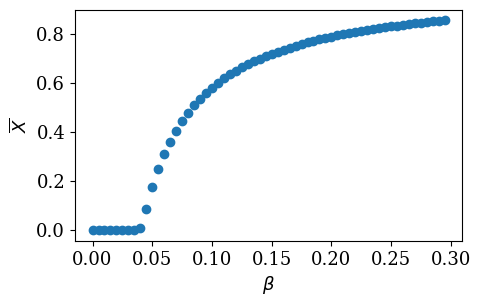

In [6]:
plt.figure(figsize=(5,3))
plt.plot(Rs, X_mean_epi, 'o')
#plt.plot(Rs, X_mean_low, 'o')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\overline{X}$')
plt.show()

In [7]:
def compute_mse(mat, dynamics, args, delta):
    initial_state = np.random.random(N)
    
    # Compute steady state
    steady_state = CF.Numerical_Integration(mat, dynamics, initial_state, show=False, args=args)
    
    ### Compute jacobian from model
    # Compute jacobian
    jacobian, lmbd = CF.Jacobian(mat, dynamics, steady_state[-1], norm=True, args=args, return_eig=True)
    
    # Compute average jacobian distance
    avg_mat, avg_dd, jac_dist_mod = average_distance(jacobian, return_snapshot=True)
    
    ### Compute from simulations
    # Simulate perburbated dynamics
    perturbed = []
    times = np.linspace(0, N, num = N+1) / lmbd

    for i in range(N):
        if i%10==0:
            print(i)
        tmp = CF.myNumerical_Integration_perturbation(nx.from_numpy_array(mat), dynamics, steady_state[-1], i, delta, times=times, args=args)
        perturbed.append(tmp[1:])
    
    perturbed = np.stack(perturbed)
    
    # Compute jacobian
    jac_dist_emp = np.zeros((N,N,N))

    for i in range(0,N-1):
        for j in range(i+1,N):
            tmp = ( (perturbed[i]-perturbed[j])**2).sum(axis=1)
            jac_dist_emp[:,i,j] = np.sqrt(tmp)
            jac_dist_emp[:,j,i] = jac_dist_emp[:,i,j]
        
    jac_dist_emp /= delta
    
    ### Compute MSE
    mse = ( (jac_dist_mod - jac_dist_emp)**2 ).mean(axis=2).mean(axis=1)
    mse_norm = tmp = ( (jac_dist_mod - jac_dist_emp)**2 / (jac_dist_emp)**2 )#.nanmean(axis=2).nanmean(axis=1)
    mse_norm = np.nanmean(mse_norm, axis=2)
    mse_norm = np.nanmean(mse_norm, axis=1)
    
    return mse, mse_norm, jac_dist_emp, jac_dist_mod

In [50]:
deltas = [0.01, 0.05, 0.1, 0.2, 0.3]
mse_deltas = []
mse_norm_deltas = []

for delta in deltas:
    print(f'########## delta={delta} ##########')
    mse, mse_norm, jac_dist_emp, jac_dist_mod = compute_mse(mat, dynamics, args, delta)
    mse_deltas.append(mse)
    mse_norm_deltas.append(mse_norm)

########## delta=0.01 ##########
[1, 0.1]
[1, 0.1]
Normalizing jacobian - $\lambda_{max}$=3.0876606419760853


  0%|          | 0/128 [00:00<?, ?it/s]

0
10
20
30
40
50
60
70
80
90
100
110
120


/tmp/ipykernel_95032/2101761973.py:40: RuntimeWarning: invalid value encountered in true_divide
  mse_norm = tmp = ( (jac_dist_mod - jac_dist_emp)**2 / (jac_dist_emp)**2 )#.nanmean(axis=2).nanmean(axis=1)


########## delta=0.05 ##########
[1, 0.1]
[1, 0.1]
Normalizing jacobian - $\lambda_{max}$=3.0876606419768984


  0%|          | 0/128 [00:00<?, ?it/s]

0
10
20
30
40
50
60
70
80
90
100
110
120
########## delta=0.1 ##########
[1, 0.1]
[1, 0.1]
Normalizing jacobian - $\lambda_{max}$=3.0876606419766173


  0%|          | 0/128 [00:00<?, ?it/s]

0
10
20
30
40
50
60
70
80
90
100
110
120
########## delta=0.2 ##########
[1, 0.1]
[1, 0.1]
Normalizing jacobian - $\lambda_{max}$=3.0876606419758192


  0%|          | 0/128 [00:00<?, ?it/s]

0
10
20
30
40
50
60
70
80
90
100
110
120
########## delta=0.3 ##########
[1, 0.1]
[1, 0.1]
Normalizing jacobian - $\lambda_{max}$=3.0876606419784647


  0%|          | 0/128 [00:00<?, ?it/s]

0
10
20
30
40
50
60
70
80
90
100
110
120


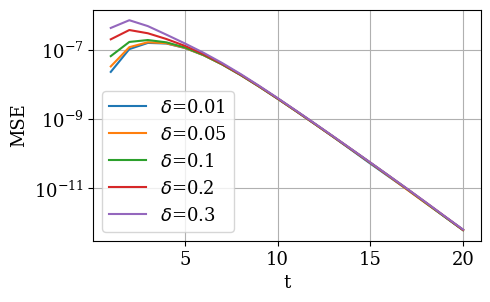

In [53]:
tmax = 20

plt.figure(figsize=(5,3))

for i, mse in enumerate(mse_deltas):
    plt.plot(np.arange(tmax)+1, mse[:tmax], label=r'$\delta$'+f'={deltas[i]}')
    
plt.xlabel('t')
plt.ylabel('MSE')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

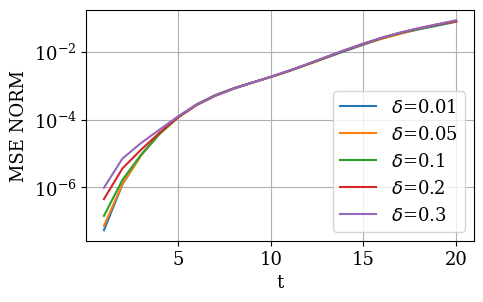

In [55]:
tmax = 20

plt.figure(figsize=(5,3))

for i, mse in enumerate(mse_norm_deltas):
    plt.plot(np.arange(tmax)+1, mse[:tmax], label=r'$\delta$'+f'={deltas[i]}')
    
plt.xlabel('t')
plt.ylabel('MSE NORM')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

In [8]:
Rs = np.linspace(0.035, 0.05, 31)
print(Rs)

[0.035  0.0355 0.036  0.0365 0.037  0.0375 0.038  0.0385 0.039  0.0395
 0.04   0.0405 0.041  0.0415 0.042  0.0425 0.043  0.0435 0.044  0.0445
 0.045  0.0455 0.046  0.0465 0.047  0.0475 0.048  0.0485 0.049  0.0495
 0.05  ]


In [9]:
#Rs = [0.035, 0.0375, 0.04, 0.0425, 0.045, 0.0475, 0.05]
delta = 0.01

mse_rs = []
mse_norm_rs = []

for R in Rs:
    print(f'########## R={R} ##########')
    args = [B, R]
    mse, mse_norm, jac_dist_emp, jac_dist_mod = compute_mse(mat, dynamics, args, delta)
    mse_rs.append(mse)
    mse_norm_rs.append(mse_norm)

########## R=0.035 ##########
[1, 0.035]
[1, 0.035]
Normalizing jacobian - $\lambda_{max}$=1.2466604375750383


  0%|          | 0/128 [00:00<?, ?it/s]

0
10
20
30
40
50
60
70
80
90
100
110
120


/tmp/ipykernel_95411/2101761973.py:40: RuntimeWarning: invalid value encountered in true_divide
  mse_norm = tmp = ( (jac_dist_mod - jac_dist_emp)**2 / (jac_dist_emp)**2 )#.nanmean(axis=2).nanmean(axis=1)


########## R=0.035500000000000004 ##########
[1, 0.035500000000000004]
[1, 0.035500000000000004]
Normalizing jacobian - $\lambda_{max}$=1.2502192527158738


  0%|          | 0/128 [00:00<?, ?it/s]

0
10
20
30
40
50
60
70
80
90
100
110
120
########## R=0.036000000000000004 ##########
[1, 0.036000000000000004]
[1, 0.036000000000000004]
Normalizing jacobian - $\lambda_{max}$=1.2538054180076394


  0%|          | 0/128 [00:00<?, ?it/s]

0
10
20
30
40
50
60
70
80
90
100
110
120
########## R=0.036500000000000005 ##########
[1, 0.036500000000000005]
[1, 0.036500000000000005]
Normalizing jacobian - $\lambda_{max}$=1.2574323085649444


  0%|          | 0/128 [00:00<?, ?it/s]

0
10
20
30
40
50
60
70
80
90
100
110
120
########## R=0.037000000000000005 ##########
[1, 0.037000000000000005]
[1, 0.037000000000000005]
Normalizing jacobian - $\lambda_{max}$=1.2611264646237799


  0%|          | 0/128 [00:00<?, ?it/s]

0
10
20
30
40
50
60
70
80
90
100
110
120
########## R=0.037500000000000006 ##########
[1, 0.037500000000000006]
[1, 0.037500000000000006]
Normalizing jacobian - $\lambda_{max}$=1.264937534298733


  0%|          | 0/128 [00:00<?, ?it/s]

0
10
20
30
40
50
60
70
80
90
100
110
120
########## R=0.038000000000000006 ##########
[1, 0.038000000000000006]
[1, 0.038000000000000006]
Normalizing jacobian - $\lambda_{max}$=1.2689009647069438


  0%|          | 0/128 [00:00<?, ?it/s]

0
10
20
30
40
50
60
70
80
90
100
110
120
########## R=0.038500000000000006 ##########
[1, 0.038500000000000006]
[1, 0.038500000000000006]
Normalizing jacobian - $\lambda_{max}$=1.2731402266467386


  0%|          | 0/128 [00:00<?, ?it/s]

0
10
20
30
40
50
60
70
80
90
100
110
120
########## R=0.03900000000000001 ##########
[1, 0.03900000000000001]
[1, 0.03900000000000001]
Normalizing jacobian - $\lambda_{max}$=1.2776862366984847


  0%|          | 0/128 [00:00<?, ?it/s]

0
10
20
30
40
50
60
70
80
90
100
110
120
########## R=0.03950000000000001 ##########
[1, 0.03950000000000001]
[1, 0.03950000000000001]
Normalizing jacobian - $\lambda_{max}$=1.282743997207538


  0%|          | 0/128 [00:00<?, ?it/s]

0
10
20
30
40
50
60
70
80
90
100
110
120
########## R=0.04 ##########
[1, 0.04]
[1, 0.04]
Normalizing jacobian - $\lambda_{max}$=1.2884904854187949


  0%|          | 0/128 [00:00<?, ?it/s]

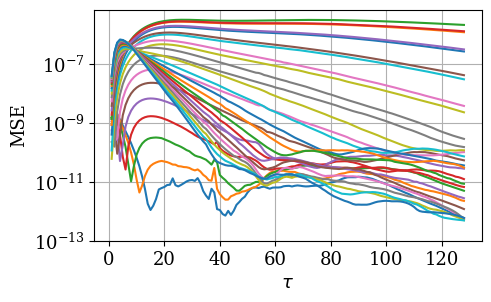

In [302]:
tmax = N#20

plt.figure(figsize=(5,3))

for i, mse in enumerate(mse_rs):
    plt.plot(np.arange(tmax)+1, mse[:tmax], label=f'R={Rs[i]}')
    
plt.xlabel(r'$\tau$')
plt.ylabel('MSE')
plt.yscale('log')
plt.ylim(1e-13,None)
plt.grid()
#plt.legend()
plt.show()

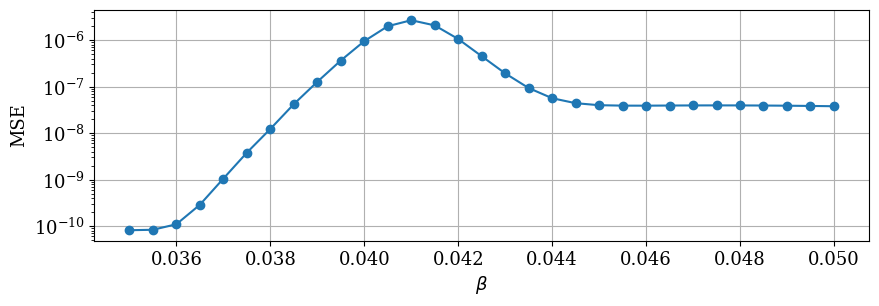

In [335]:
plt.figure(figsize=(10,3))

plt.plot(Rs, np.mean(mse_rs[:tmax], axis=1), '-o')
plt.xlabel(r'$\beta$')
plt.ylabel('MSE')
plt.yscale('log')
plt.grid()

plt.show()

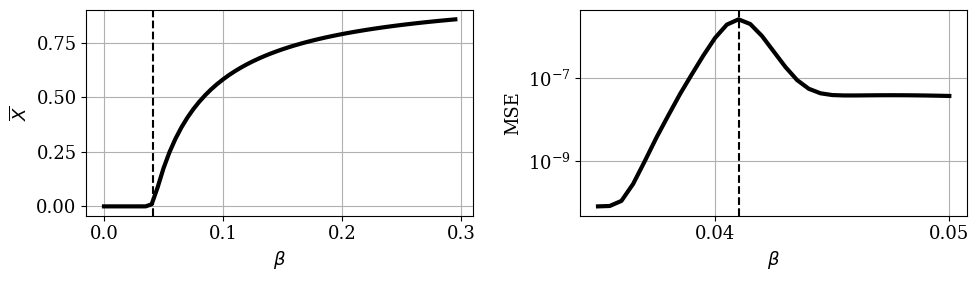

In [14]:
plt.figure(figsize=(10,3))

crit = 0.041
lw=3
tmax = N

plt.subplot(1,2,1)

plt.plot(np.arange(0.0, 0.3, 0.005), X_mean_epi, '-', c='k', lw=lw)
#plt.plot(Rs, X_mean_low, 'o')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\overline{X}$')
plt.grid()
plt.locator_params(nbins=4)
plt.axvline(crit, c='k', ls='--')

plt.subplot(1,2,2)

plt.plot(np.linspace(0.035, 0.05, 31), np.mean(mse_rs[:tmax], axis=1), '-', c='k', lw=lw)
plt.xlabel(r'$\beta$')
plt.ylabel('MSE')
plt.yscale('log')
plt.grid()
plt.xticks([0.04, 0.05])
plt.axvline(crit, c='k', ls='--')

plt.tight_layout()
plt.savefig('figures/figure_sis.png', bbox_inches='tight', pad_inches=0.1, dpi=300)
plt.show()

# What happens close to the critical point? Show the trajectory

In [69]:
R = 0.04
args = [1, R]

initial_state = np.random.random(N)

# Compute steady state
steady_state = CF.Numerical_Integration(mat, dynamics, initial_state, show=False, args=args)
    
### Compute jacobian from model
# Compute jacobian
jacobian, lmbd = CF.Jacobian(mat, dynamics, steady_state[-1], norm=True, args=args, return_eig=True)
    
# Compute average jacobian distance
#avg_mat, avg_dd, jac_dist_mod = average_distance(jacobian, return_snapshot=True)
    
### Compute from simulations
# Simulate perburbated dynamics
perturbed = []
times = np.linspace(0, N, num = N+1) / lmbd

for i in range(N):
    if i%10==0:
        print(i)
    tmp = CF.myNumerical_Integration_perturbation(nx.from_numpy_array(mat), dynamics, steady_state[-1], i, delta, times=times, args=args)
    perturbed.append(tmp[1:])
    
perturbed = np.stack(perturbed)

[1, 0.04]
[1, 0.04]
Normalizing jacobian - $\lambda_{max}$=1.283818202977758
0
10
20
30
40
50
60
70
80
90
100
110
120


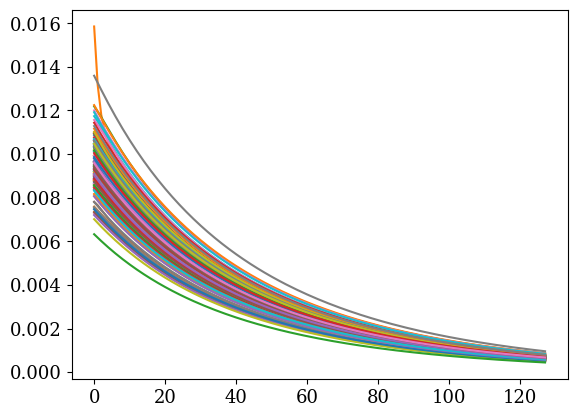

In [70]:
plt.plot(perturbed[1])
plt.show()

In [72]:
from scipy.linalg import expm

In [87]:
evo = [expm(jacobian*tau) for tau in times[1:]]
evo = np.array(evo)

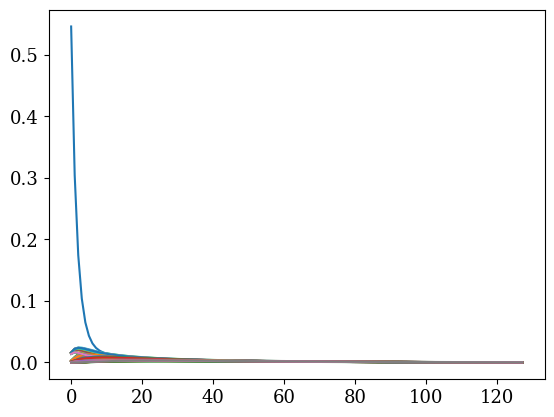

In [88]:
plt.plot(evo[:,0])
plt.show()

# Simulate regulatory dynamics $R_2$(a=1/2, h=1)

In [16]:
B = 1
a = 1
h = 1.5

In [23]:
Rs = np.arange(0.0, 0.5, 0.005)
B = 1
a = 1
h = 1.5

X_mean = np.zeros(len(Rs))
X_mean_low = np.zeros(len(Rs))
X_mean_med = np.zeros(len(Rs))

dynamics = 'Regulatory'
init_state = np.random.random(N) * 10
init_state_low = np.zeros(N) #np.random.random(N) *1e-10
init_state_med = np.random.random(N)*1e-4

times = np.linspace(0,200,200)

for i, R in enumerate(Rs):
    params = [B, R, a, h]
    
    res = CF.Numerical_Integration(mat, dynamics, init_state, args=params, show=False, times=times)
    X_mean[i] = res[-1].mean()
    
    res = CF.Numerical_Integration(mat, dynamics, init_state_low, args=params, show=False, times=times)
    X_mean_low[i] = res[-1].mean()
    
    res = CF.Numerical_Integration(mat, dynamics, init_state_med, args=params, show=False, times=times)
    X_mean_med[i] = res[-1].mean()

[1, 0.0, 1, 1.5]
[1, 0.0, 1, 1.5]
[1, 0.0, 1, 1.5]
[1, 0.005, 1, 1.5]
[1, 0.005, 1, 1.5]
[1, 0.005, 1, 1.5]
[1, 0.01, 1, 1.5]
[1, 0.01, 1, 1.5]
[1, 0.01, 1, 1.5]
[1, 0.015, 1, 1.5]
[1, 0.015, 1, 1.5]
[1, 0.015, 1, 1.5]
[1, 0.02, 1, 1.5]
[1, 0.02, 1, 1.5]
[1, 0.02, 1, 1.5]
[1, 0.025, 1, 1.5]
[1, 0.025, 1, 1.5]
[1, 0.025, 1, 1.5]
[1, 0.03, 1, 1.5]
[1, 0.03, 1, 1.5]
[1, 0.03, 1, 1.5]
[1, 0.035, 1, 1.5]
[1, 0.035, 1, 1.5]
[1, 0.035, 1, 1.5]
[1, 0.04, 1, 1.5]
[1, 0.04, 1, 1.5]
[1, 0.04, 1, 1.5]
[1, 0.045, 1, 1.5]
[1, 0.045, 1, 1.5]
[1, 0.045, 1, 1.5]
[1, 0.05, 1, 1.5]
[1, 0.05, 1, 1.5]
[1, 0.05, 1, 1.5]
[1, 0.055, 1, 1.5]
[1, 0.055, 1, 1.5]
[1, 0.055, 1, 1.5]
[1, 0.06, 1, 1.5]
[1, 0.06, 1, 1.5]
[1, 0.06, 1, 1.5]
[1, 0.065, 1, 1.5]
[1, 0.065, 1, 1.5]
[1, 0.065, 1, 1.5]
[1, 0.07, 1, 1.5]
[1, 0.07, 1, 1.5]
[1, 0.07, 1, 1.5]
[1, 0.075, 1, 1.5]
[1, 0.075, 1, 1.5]
[1, 0.075, 1, 1.5]
[1, 0.08, 1, 1.5]
[1, 0.08, 1, 1.5]
[1, 0.08, 1, 1.5]
[1, 0.085, 1, 1.5]
[1, 0.085, 1, 1.5]
[1, 0.085, 1, 1.5]
[1, 

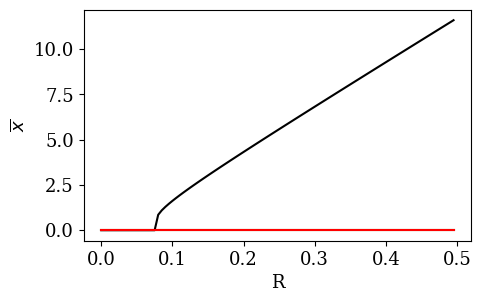

In [24]:
plt.figure(figsize=(5,3))

plt.plot(Rs, X_mean, c='k')
plt.plot(Rs, X_mean_low, c='r')
plt.plot(Rs, X_mean_med, c='g', zorder=1)
plt.xlabel('R')
plt.ylabel(r'$\overline{x}$')

plt.show()

In [31]:
R = 2
args = [1, R, a, h]

times = np.linspace(0,10,200)

dynamics = 'Regulatory'

# Compute steady state
steady_states = CF.Numerical_Integration(mat, dynamics, init_state_low, show=False, args=args, times=times)
    
deltas = [.001, .01, .1]
res_reg = []
    
for delta in deltas:
    delta_vec = np.zeros(N)
    delta_vec[0] += delta
    tmp = CF.Numerical_Integration(mat, dynamics, steady_states[-1]+delta_vec, show=False, args=args, times=times)
    res_reg.append(tmp)

[1, 2, 1, 1.5]
[1, 2, 1, 1.5]
[1, 2, 1, 1.5]
[1, 2, 1, 1.5]


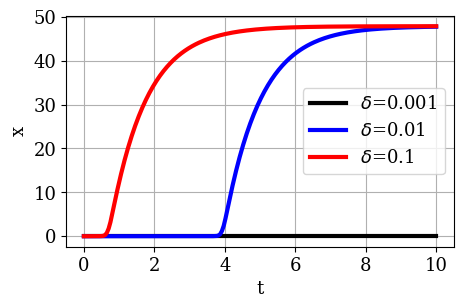

In [32]:
cs = ['k', 'b', 'r', 'g']

plt.figure(figsize=(5,3))

for i, tmp in enumerate(res_reg):
    plt.plot(times, tmp.mean(axis=1), c=cs[i], label=r'$\delta$='+str(deltas[i]), lw=3)
    
plt.xlabel('t')
plt.ylabel('x')
plt.legend()
plt.grid()
#plt.yscale('log')
plt.show()

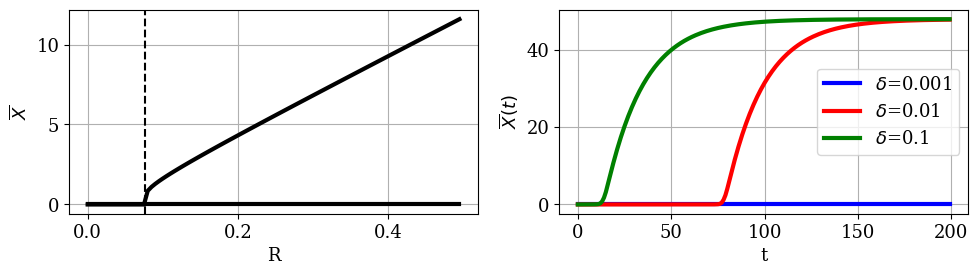

In [42]:
lw = 3
crit = 0.077

plt.figure(figsize=(10,3))

plt.subplot(1,2,1)

plt.plot(Rs, X_mean, '-', c='k', lw=lw)
plt.plot(Rs, X_mean_low, '-', c='k', lw=lw)
#plt.plot(Rs, X_mean_med, zorder=-1)
plt.xlabel('R')
plt.ylabel(r'$\overline{X}$')
plt.grid()
plt.locator_params(nbins=4)
plt.axvline(crit, c='k', ls='--')

plt.subplot(1,2,2)

cs = ['b', 'r', 'g']

for i, tmp in enumerate(res_reg):
    plt.plot(tmp.mean(axis=1), c=cs[i], label=r'$\delta$='+str(deltas[i]), lw=lw)
    
plt.xlabel('t')
plt.ylabel(r'$\overline{X}(t)$')
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig('figures/figure_reg.png', bbox_inches='tight', pad_inches=0.1, dpi=300)
plt.show()

# Simulate SIS model

In [43]:
from numba import njit

@njit
def simulate_sis_model(adj_matrix, beta, mu, num_iterations, initial_state, dt):
    num_nodes = adj_matrix.shape[0]
    state = np.zeros((num_iterations, num_nodes), dtype=np.int32)
    state[0] = initial_state
    
    beta = beta * dt
    mu = mu * dt
    
    ### Loop over times
    for t in range(num_iterations-1):
        ### Loop over nodes
        for i in range(num_nodes):
            if state[t,i] == 1:  # Infected node
                for j in range(num_nodes):
                    if adj_matrix[i, j] == 1:  # Connected node
                        if state[t,j] == 0:  # Susceptible node
                            if np.random.rand() < beta:
                                state[t+1,j] = 1  # Infect the susceptible node
                    
                if np.random.rand() > mu:
                    state[t+1,i] = 1
                    
    return state

/home/barzon/.local/lib/python3.8/site-packages/numba/core/errors.py:175: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [44]:
dt = 0.1

beta = 0.04
mu = 1
num_iterations = int(5e5)
initial_state = np.ones(mat.shape[0], dtype=np.int32)

states = simulate_sis_model(mat, beta, mu, num_iterations, initial_state, dt)

t_death = np.where(states.mean(axis=1)==0)[0]
if len(t_death)>0:
    states = states[:t_death[0]]
    
if False:
    transient = states.shape[0] // 10
    print(transient)
    states = states[transient:]

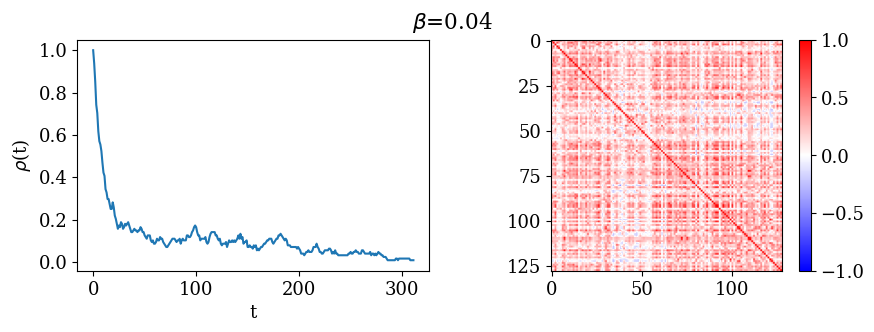

In [45]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(states.mean(axis=1))
plt.xlabel('t')
plt.ylabel(r'$\rho$(t)')

plt.subplot(1,2,2)
plt.imshow(np.corrcoef(states.T), cmap='bwr', vmin=-1, vmax=1)
plt.colorbar()
plt.suptitle(r'$\beta$='+str(np.round(beta,3)))
plt.show()

In [63]:
betas = np.linspace(0.04, .1, 7)

#betas = np.linspace(0.01, 0.1, 10)
print(betas)

[0.04 0.05 0.06 0.07 0.08 0.09 0.1 ]


In [64]:
ress = []
corrs = []

dt = 0.01

for beta in betas:
    print(beta)
    states = simulate_sis_model(mat, beta, mu, num_iterations, initial_state, dt)
        
    t_death = np.where(states.mean(axis=1)==0)[0]

    if len(t_death) > 0:
        t_death = t_death[0]
        states = states[:t_death]
    
    transient = states.shape[0] // 10
    states = states[transient:]
    
    ress.append(states)

0.04
0.05
0.06
0.07
0.08
0.09
0.1


/home/barzon/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/barzon/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


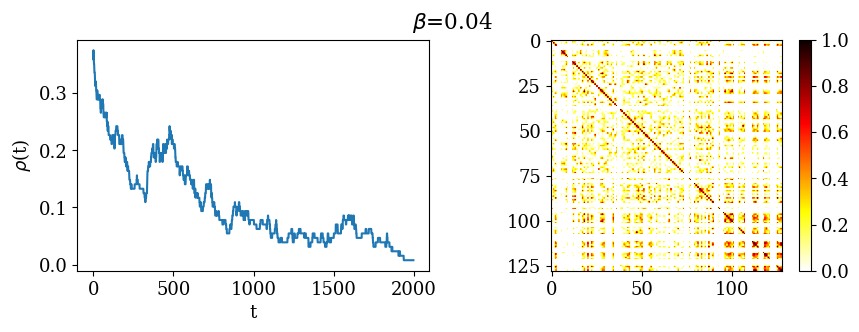

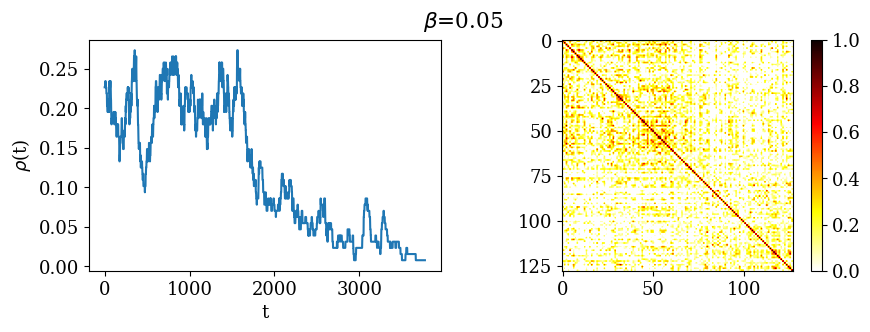

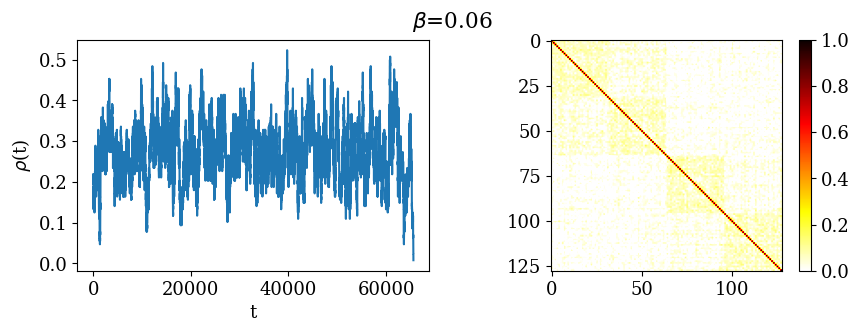

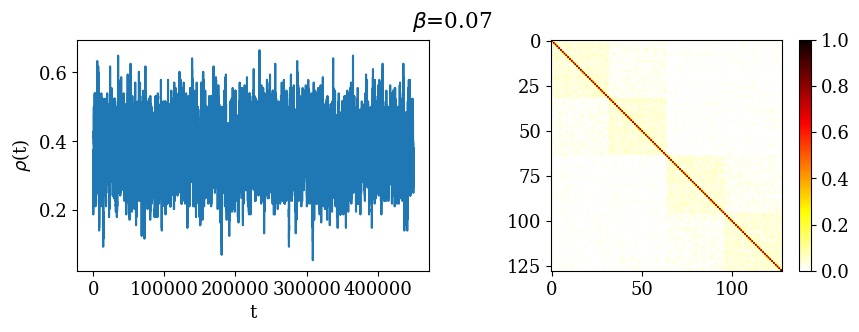

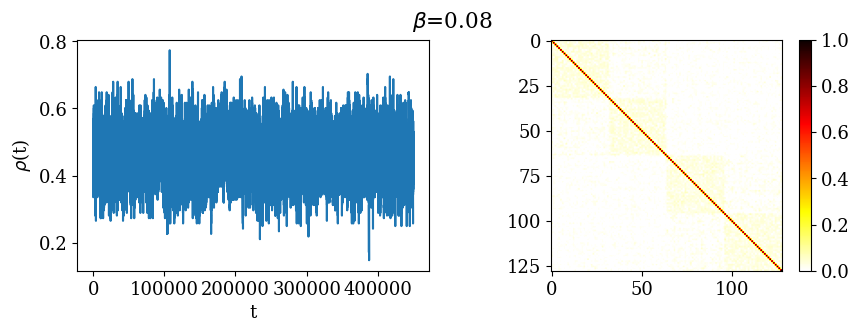

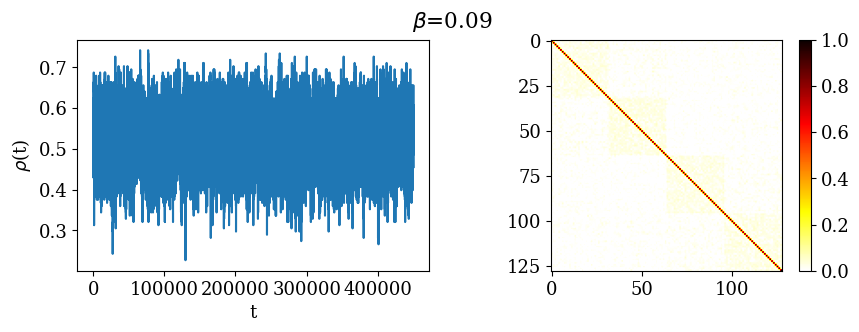

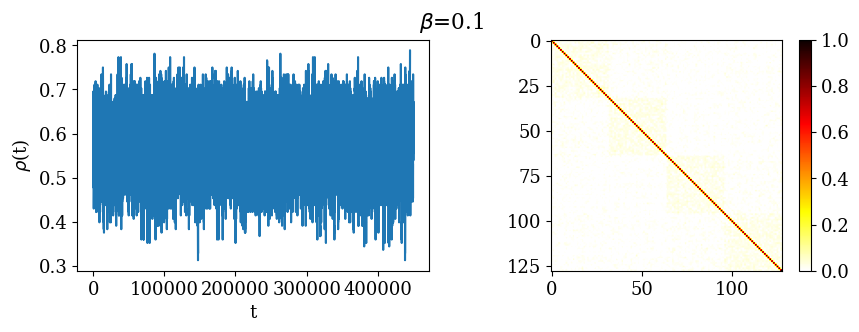

In [48]:
for i, tmp in enumerate(ress):
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1)
    plt.plot(tmp.mean(axis=1))
    plt.xlabel('t')
    plt.ylabel(r'$\rho$(t)')
    
    plt.subplot(1,2,2)
    plt.imshow(np.corrcoef(tmp.T), cmap='hot_r', vmin=0, vmax=1)
    plt.colorbar()
    plt.suptitle(r'$\beta$='+str(np.round(betas[i],3)))
    plt.show()

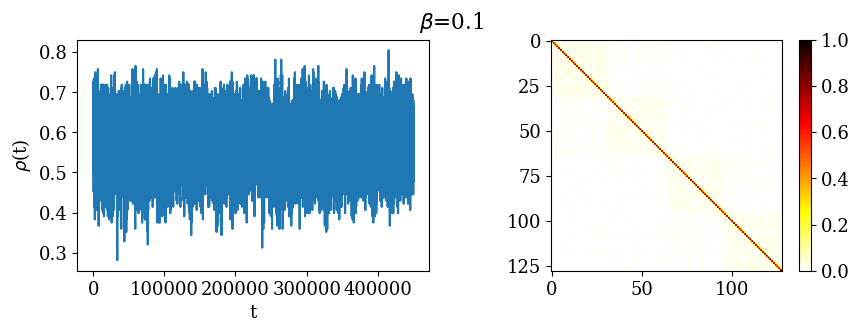

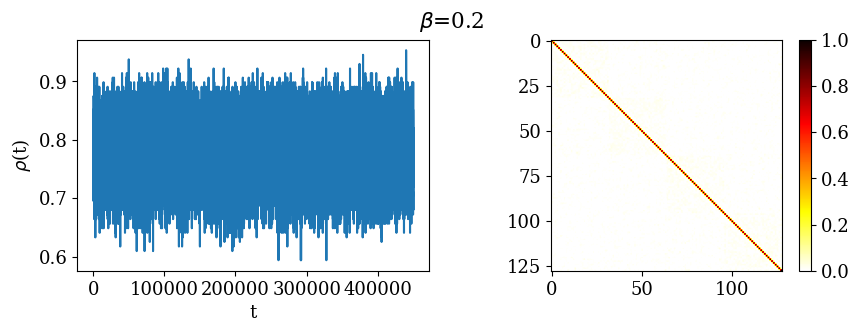

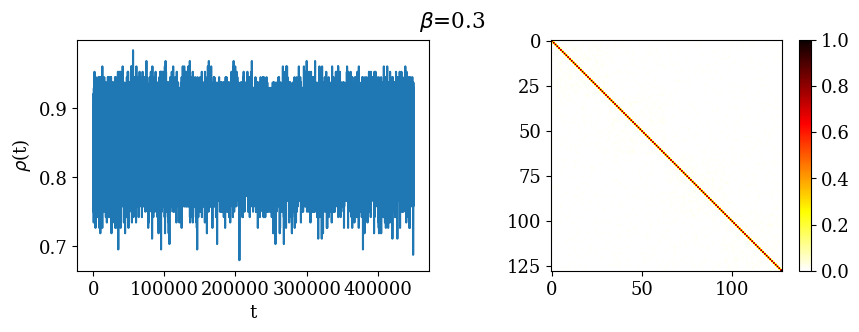

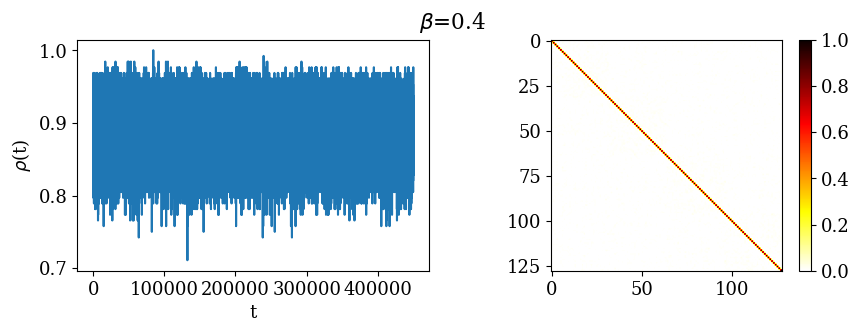

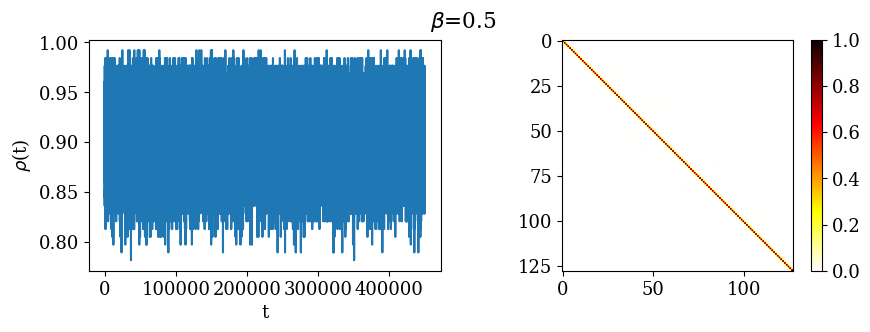

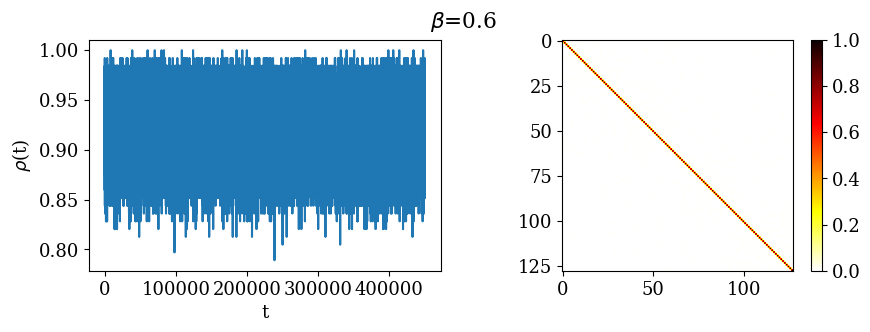

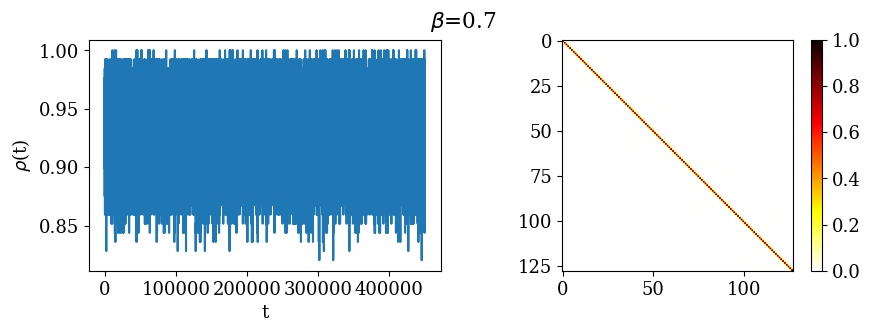

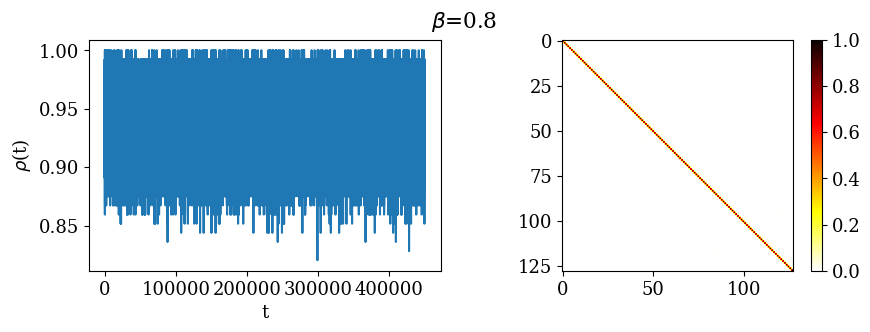

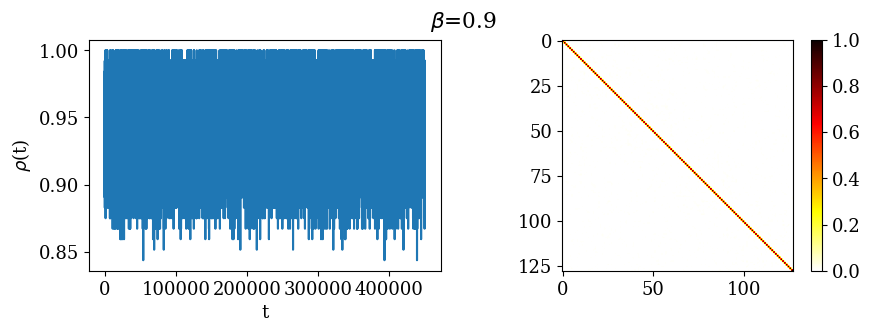

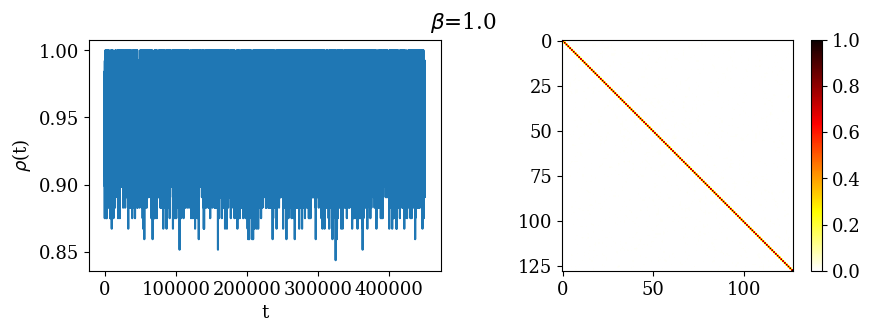

In [828]:
for i, tmp in enumerate(ress):
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1)
    plt.plot(tmp.mean(axis=1))
    plt.xlabel('t')
    plt.ylabel(r'$\rho$(t)')
    
    plt.subplot(1,2,2)
    plt.imshow(np.corrcoef(tmp.T), cmap='hot_r', vmin=0, vmax=1)
    plt.colorbar()
    plt.suptitle(r'$\beta$='+str(np.round(betas[i],3)))
    plt.show()

# Compute Jacobian distance

In [49]:
import utils.CommonFunctions as cf

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform, pdist
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import cophenet

In [50]:
### Compare prediction w Jacobian distance
dynamics = 'Epidemics'

B = 1
#betas = np.linspace(0.1, 1., 10)
betas = np.linspace(0.04, .1, 7)
params = [[B, beta] for beta in betas]
print(params)

[[1, 0.04], [1, 0.05], [1, 0.06], [1, 0.07], [1, 0.08], [1, 0.09], [1, 0.1]]


JACOBIAN DISTANCE
Dynamics: Epidemics
[1, 0.04]


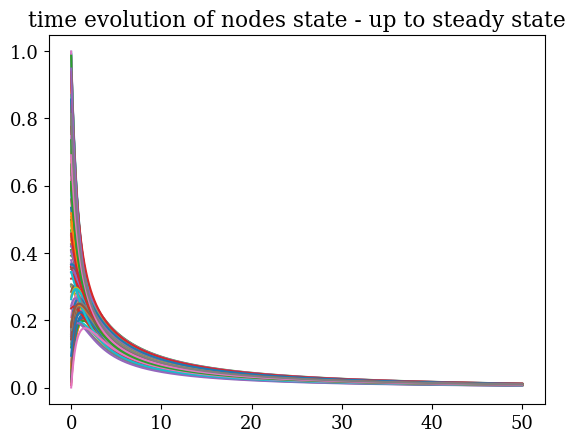

[1, 0.04]
Normalizing jacobian - $\lambda_{max}$=1.2884748110533795
- Compute average distance...


  0%|          | 0/128 [00:00<?, ?it/s]

- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Epidemics
[1, 0.05]


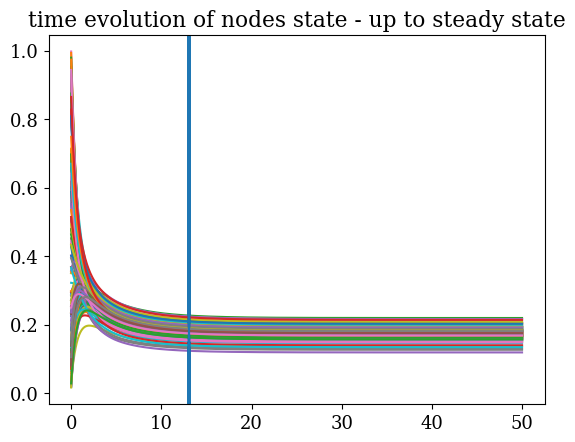

[1, 0.05]
Normalizing jacobian - $\lambda_{max}$=1.509335332423377
- Compute average distance...


  0%|          | 0/128 [00:00<?, ?it/s]

- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Epidemics
[1, 0.06]


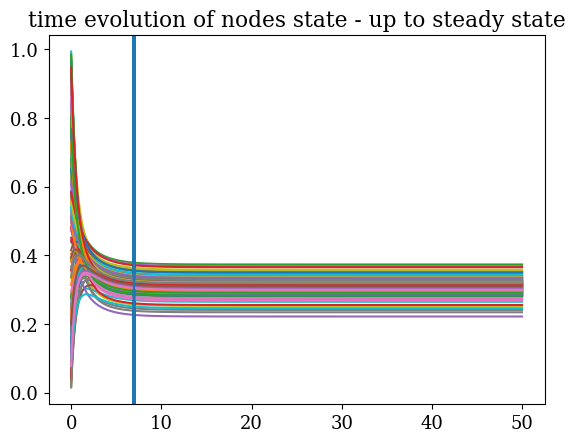

[1, 0.06]
Normalizing jacobian - $\lambda_{max}$=1.7663939704044742
- Compute average distance...


  0%|          | 0/128 [00:00<?, ?it/s]

- Compute hierarchical clustering with method ward...
JACOBIAN DISTANCE
Dynamics: Epidemics
[1, 0.07]


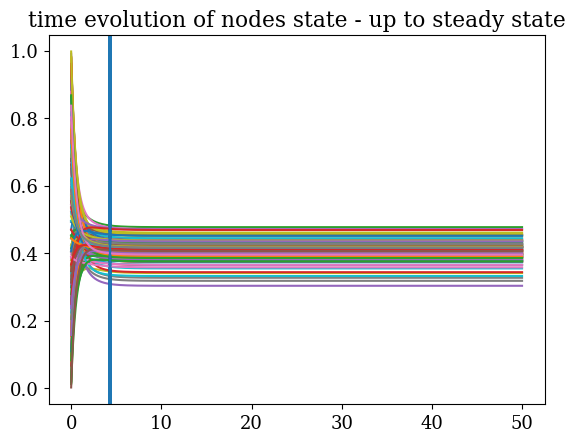

[1, 0.07]
Normalizing jacobian - $\lambda_{max}$=2.0419380820070208
- Compute average distance...


  0%|          | 0/128 [00:00<?, ?it/s]

In [51]:
res_all = []

for param in params:
    res = distance.jacobian_distance(mat, dynamics, norm=True, args=param, name='modular_sis', title=None, comms=None, show=False)
    res_all.append(res)

0.042138451002406103


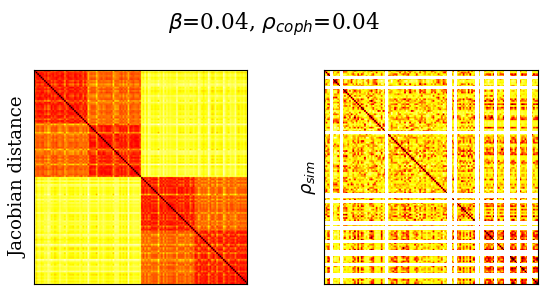

0.09119329953559693


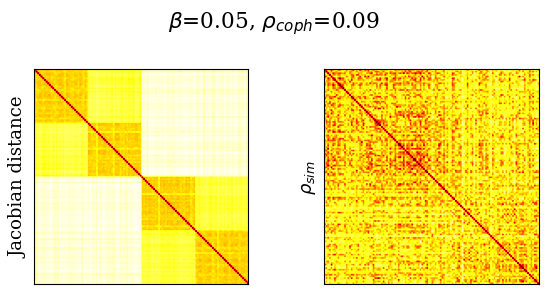

0.7183865735315058


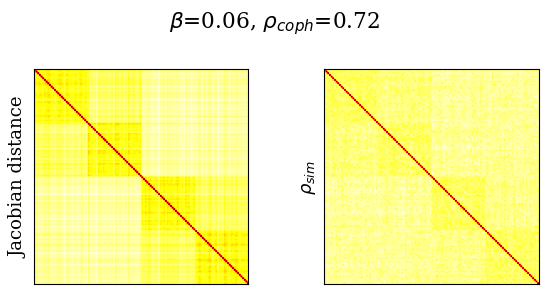

0.9675347733553108


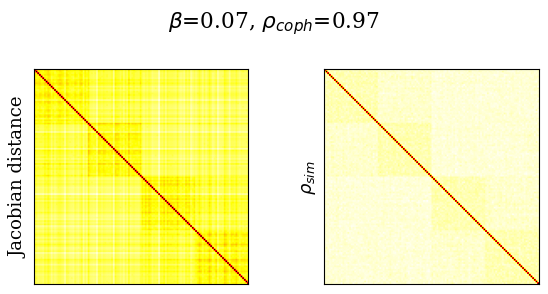

0.8694729118629656


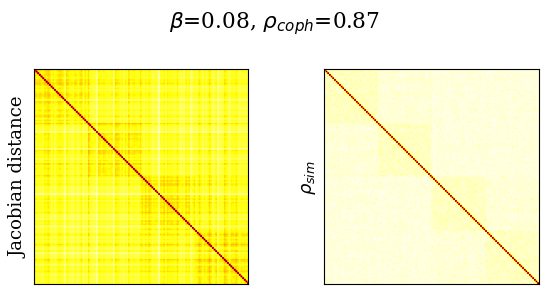

0.932849089543584


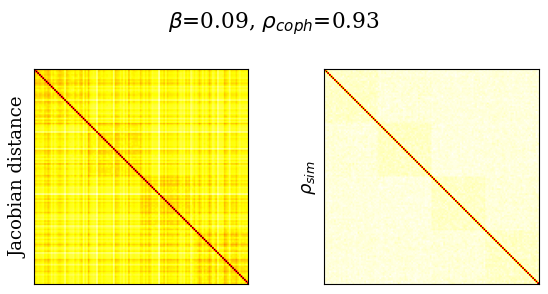

0.9122580263725767


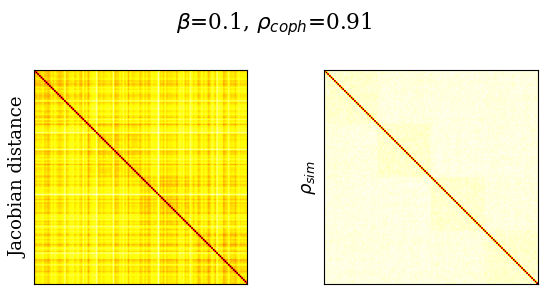

In [53]:
res_coph = np.zeros(len(betas))


for i, beta in enumerate(betas):
    # Compute dendrogram from jacobian
    Z_jac = linkage(squareform(res_all[i][0]), method='ward')
    dist_jac = cophenet(Z_jac)
    
    # Compute dendrogram from simulations
    tmp = np.corrcoef(ress[i].T)
    #Z_sim = linkage(pdist(tmp), method='ward')
    tmp[tmp<0] = 0
    tmp[np.isnan(tmp)] = 0
    tmp = 1 - tmp
    Z_sim = linkage(squareform(tmp, checks=False), method='ward')
    dist_sim = cophenet(Z_sim)
    
    res_coph[i] = np.corrcoef(dist_jac, dist_sim)[0,1]
    print(res_coph[i])
    
    plt.figure(figsize=(6,3))
    
    plt.subplot(1,2,1)
    plt.imshow(res_all[i][0], cmap='hot')
    plt.xticks([])
    plt.yticks([])
    plt.ylabel('Jacobian distance')
    
    plt.subplot(1,2,2)
    plt.imshow(np.corrcoef(ress[i].T), cmap='hot_r')
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(r'$\rho_{sim}$')
    
    plt.suptitle(r'$\beta$='+str(np.round(beta, 2))+r', $\rho_{coph}$='+str(np.round(res_coph[i],2)))
    plt.tight_layout()
    plt.show()

In [58]:
idx = np.where(betas==0.07)[0][0]
print(idx)

3


In [65]:
ress[idx].shape

(450000, 128)

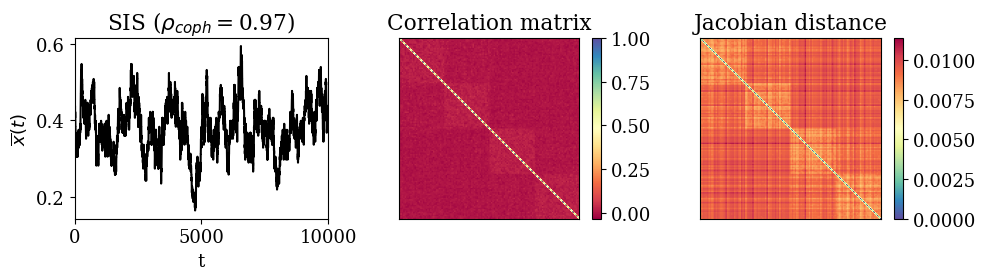

In [123]:
'''
fig = plt.figure(figsize=(10,6))
gs = GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1.5])
ax1 = fig.add_subplot(gs[0,:])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[1,1])
'''

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,3))

# Time evolution
tmax = int(1e4)
ax1.plot(ress[idx][-tmax:].mean(axis=1), c='k')
ax1.set_xlim(0,tmax)
ax1.set_xlabel('t')
ax1.set_ylabel(r'$\overline{x}(t)$')
ax1.set_title( r'SIS ($\rho_{coph}=$'+str(np.round(res_coph[idx],2)) + ')' )
ax1.locator_params(axis='both', nbins=3)

# Correlation
tmax = int(2e4)
im2 = ax2.imshow(np.corrcoef(ress[i].T), cmap='Spectral')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('Correlation matrix')
fig.colorbar(im2, ax=ax2)

# Jacobian distance
tmax = int(1e4)
im3 = ax3.imshow(res_all[idx][0], cmap='Spectral_r')
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_title('Jacobian distance')
fig.colorbar(im3, ax=ax3)

#plt.suptitle('SIS')
plt.tight_layout()
plt.savefig('figures/figure_sis.png', bbox_inches='tight', pad_inches=0.1, dpi=300)
plt.show()

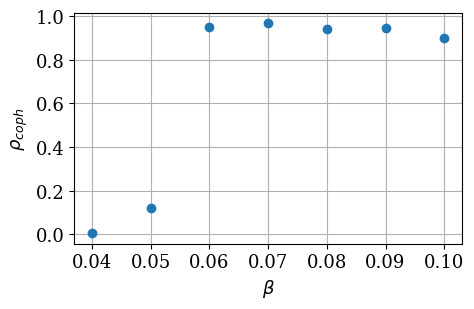

In [852]:
plt.figure(figsize=(5,3))

plt.plot(betas, res_coph, 'o')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\rho_{coph}$')
plt.grid()

plt.show()

# Noisy voter model

In [142]:
@njit
def simulate_noisy_voter_model(adj_matrix, noise_prob, num_iterations):
    num_nodes = adj_matrix.shape[0]
    states = np.zeros((num_iterations, num_nodes), dtype=np.int32)
    xx = np.array([-1,1]).astype(np.int32)
    
    # Initial conditions
    #states[0] = np.random.choice(np.array([-1, 1], dtype=np.int32), size=num_nodes)
    states[0] = np.ones(num_nodes, dtype=np.int32)
    
    for t in range(num_iterations-1):
        for i in range(num_nodes):
            if np.random.rand() < noise_prob:
                states[t+1,i] = np.random.choice(xx)  # Random state due to noise
            else:
                #print(np.sum(states[t,i]*adj_matrix[i]))
                if np.sum(states[t]*adj_matrix[i]) > 0:
                    states[t+1,i] = 1
                elif np.sum(states[t]*adj_matrix[i]) < 0:
                    states[t+1,i] = -1
                else:
                    states[t+1,i] = states[t,i]           
    
    return states

In [140]:
noise_prob = 0.8
gain = 1

num_iterations = int(1e5)

states = simulate_noisy_voter_model(gain*mat, noise_prob, num_iterations)
states[states==-1] = 0

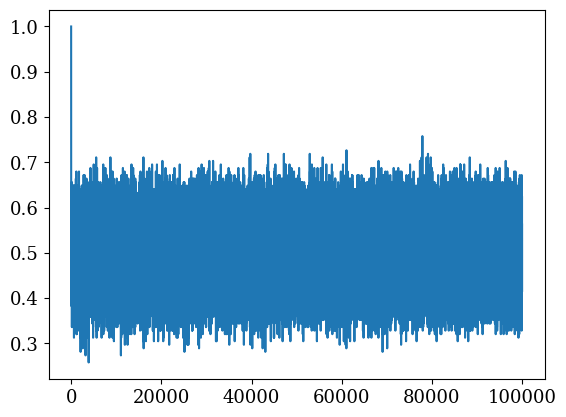

In [141]:
plt.plot(states.mean(axis=1))
plt.show()

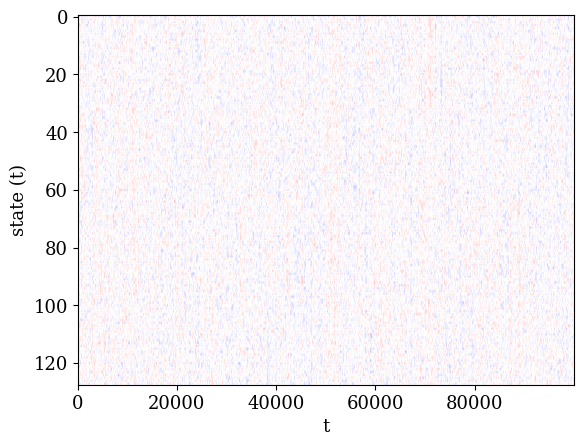

In [127]:
plt.imshow(states.T, aspect='auto', cmap='bwr')
plt.xlabel('t')
plt.ylabel('state (t)')
plt.show()

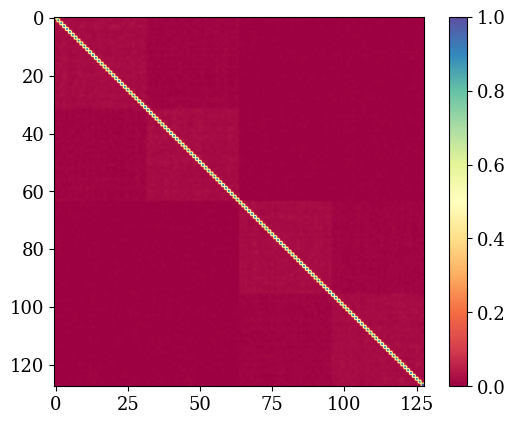

In [130]:
plt.imshow(np.corrcoef(states.T), cmap='Spectral', vmin=0)
plt.colorbar()
plt.show()

JACOBIAN DISTANCE
Dynamics: NoisyVM
[1, 1, 1]


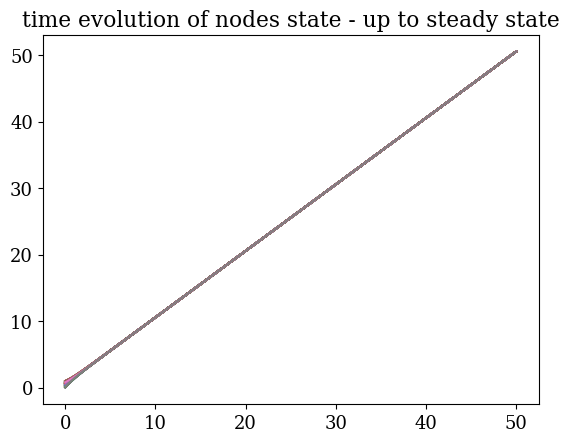

[1, 1, 1]
Normalizing jacobian - $\lambda_{max}$=1.2984853068314897
- Compute average distance...


  0%|          | 0/128 [00:00<?, ?it/s]

- Compute hierarchical clustering with method ward...


In [143]:
dynamics = 'NoisyVM'

tmp = distance.jacobian_distance(mat, dynamics, norm=True, args=[1, 1, 1], name='modular_nvm', title=None, comms=None, show=False)

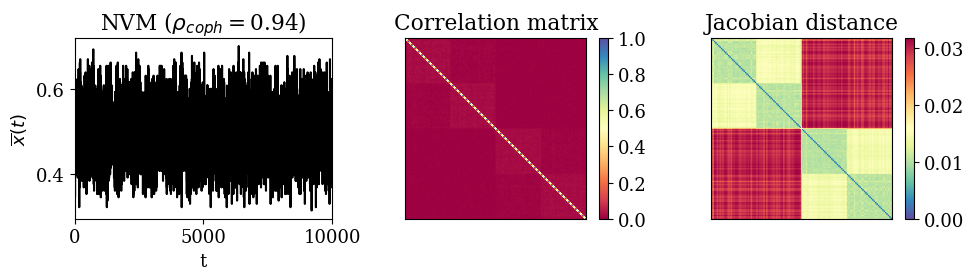

In [146]:
'''
fig = plt.figure(figsize=(10,6))
gs = GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1.5])
ax1 = fig.add_subplot(gs[0,:])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[1,1])
'''

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,3))

# Time evolution
tmax = int(1e4)
ax1.plot(states.mean(axis=1)[-tmax:], c='k')
ax1.set_xlim(0,tmax)
ax1.set_xlabel('t')
ax1.set_ylabel(r'$\overline{x}(t)$')
ax1.set_title( r'NVM ($\rho_{coph}=$'+str(0.94) + ')' )
ax1.locator_params(axis='both', nbins=3)

# Correlation
tmax = int(2e4)
im2 = ax2.imshow(np.corrcoef(states.T), cmap='Spectral', vmin=0)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('Correlation matrix')
fig.colorbar(im2, ax=ax2)

# Jacobian distance
tmax = int(1e4)
im3 = ax3.imshow(tmp[0], cmap='Spectral_r')
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_title('Jacobian distance')
fig.colorbar(im3, ax=ax3)

plt.tight_layout()
plt.savefig('figures/figure_nvm.png', bbox_inches='tight', pad_inches=0.1, dpi=300)
plt.show()